# Trigrams - MakeMore2 (19/04/2023)

What if we wanted to guess the fourth character by knowing the first $3$ ones?
We should have a counting matrix $N$ of size (in this case) $28 \cdot 28 \cdot 28 = 21952$.
For some applications we would like to look at strings of $9, 10$ characters or even more: the situation becomes exponentially untreatable.

We must find another way to "train" our system, one that does not involve counting since the latter is not scalable to $n-$grams.
We are going to ask a **Neural Network** to predict the (conditioned) probability distribution over all characters.
Furthermore, we are going to see the most simple case of Neural Network now, but then we are going to complexify it and get incredible results.

In [443]:
# https://youtu.be/TCH_1BHY58I
# https://github.com/karpathy/makemore

Now we'll try to build a multilayer perceptron (MLP).
Each character is going to be embedded in a 2D space.
We've three vectors 30D, so 90D as total dimension (28 chars + 2).
Training the network the embedding will change.
We'll have a linear transformation which transpose in an intermediate layer we can see as 100D vector.
Transforming this non-linearly (with a hyperbolic tangent) it will construct the derivatives (back propagation).
With another linear transform we'll connect all.
Exponentiating and normalizing we'll get the desired probability distribution.
Hyperparameters are the a priori defined parameters.
To do things in a good way one needs to know how to tune the hyperparameters.

In [444]:
# we now go to MLP (multilayer perceptron)....(using NLP (natural language processing))
# 'a neural probabilistic language model' (2003) chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/
# https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf
# fig 1: 4th word predicted after the three....
import random
import torch
import torch.nn.functional as  F
import matplotlib.pyplot as plt
%matplotlib inline

In [445]:
# read in all the words
random.seed(158)
words = open('data/nomi_italiani.txt', 'r').read().splitlines()
random.shuffle(words)
print(words[0:10])
print(len(words))

['argento', 'giovannino', 'licurga', 'elvira', 'marena', 'sirio', 'emilia', 'bisio', 'preziosa', 'perpetua']
9105


In [446]:
# build the vocabulary of characters and mapping to/from integers
chars = sorted(list(set(''.join(words))))

stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
print(itos)
print(stoi)

{1: '-', 2: 'a', 3: 'b', 4: 'c', 5: 'd', 6: 'e', 7: 'f', 8: 'g', 9: 'h', 10: 'i', 11: 'j', 12: 'k', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'q', 19: 'r', 20: 's', 21: 't', 22: 'u', 23: 'v', 24: 'w', 25: 'x', 26: 'y', 27: 'z', 0: '.'}
{'-': 1, 'a': 2, 'b': 3, 'c': 4, 'd': 5, 'e': 6, 'f': 7, 'g': 8, 'h': 9, 'i': 10, 'j': 11, 'k': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 'q': 18, 'r': 19, 's': 20, 't': 21, 'u': 22, 'v': 23, 'w': 24, 'x': 25, 'y': 26, 'z': 27, '.': 0}


Previous example - Markov chain, so the block size was 1.
Updating the contest means shift over the string and add the last character.
X contains the samples (what I'm looking at).
Each row of X is a trigram.
Y contains the correct answers.

In [447]:
# build the dataset

block_size = 3  # context length: how many characters do we take to predict the next one ... change it !!
# try: block_size=1 ...Markov Chain, then try = 2 and =10
X, Y = [], []  # input & label

for w in words[0:5]:
    print(w)
    context = [0]*block_size  # 000 corresponds to the character '...'
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:]+[ix]  # shift: crop and append
X = torch.tensor(X)
Y = torch.tensor(Y)

argento
... ---> a
..a ---> r
.ar ---> g
arg ---> e
rge ---> n
gen ---> t
ent ---> o
nto ---> .
giovannino
... ---> g
..g ---> i
.gi ---> o
gio ---> v
iov ---> a
ova ---> n
van ---> n
ann ---> i
nni ---> n
nin ---> o
ino ---> .
licurga
... ---> l
..l ---> i
.li ---> c
lic ---> u
icu ---> r
cur ---> g
urg ---> a
rga ---> .
elvira
... ---> e
..e ---> l
.el ---> v
elv ---> i
lvi ---> r
vir ---> a
ira ---> .
marena
... ---> m
..m ---> a
.ma ---> r
mar ---> e
are ---> n
ren ---> a
ena ---> .


If I present to my system $0 = \cdot$ I expect to find $2=a$, and so on.

In [448]:
print(X)
print(Y)

tensor([[ 0,  0,  0],
        [ 0,  0,  2],
        [ 0,  2, 19],
        [ 2, 19,  8],
        [19,  8,  6],
        [ 8,  6, 15],
        [ 6, 15, 21],
        [15, 21, 16],
        [ 0,  0,  0],
        [ 0,  0,  8],
        [ 0,  8, 10],
        [ 8, 10, 16],
        [10, 16, 23],
        [16, 23,  2],
        [23,  2, 15],
        [ 2, 15, 15],
        [15, 15, 10],
        [15, 10, 15],
        [10, 15, 16],
        [ 0,  0,  0],
        [ 0,  0, 13],
        [ 0, 13, 10],
        [13, 10,  4],
        [10,  4, 22],
        [ 4, 22, 19],
        [22, 19,  8],
        [19,  8,  2],
        [ 0,  0,  0],
        [ 0,  0,  6],
        [ 0,  6, 13],
        [ 6, 13, 23],
        [13, 23, 10],
        [23, 10, 19],
        [10, 19,  2],
        [ 0,  0,  0],
        [ 0,  0, 14],
        [ 0, 14,  2],
        [14,  2, 19],
        [ 2, 19,  6],
        [19,  6, 15],
        [ 6, 15,  2]])
tensor([ 2, 19,  8,  6, 15, 21, 16,  0,  8, 10, 16, 23,  2, 15, 15, 10, 15, 16,
         0, 13, 1

In [449]:
print(X.shape, X.dtype, Y.shape, Y.dtype)

torch.Size([41, 3]) torch.int64 torch.Size([41]) torch.int64


Now we want to predict the next character starting from trigrams.
We're going to take a 2D embedding of the 28 characters.
There are many pre-calculated embeddings in the world.

We can generate a random (normal) matrix 28x2.
In deep data analysis (what we're doing) the world is going really fast.
There is a lot of material, 99% of which are bullshits.

In [450]:
# https://pytorch.org/docs/stable/generated/torch.randn.html
C = torch.randn((28, 2))

In [451]:
print(C[5])
print(C.shape)

tensor([-0.7776,  0.3077])
torch.Size([28, 2])


Here is a plot of the embedding.
Letters are random, after the training this picture is going to change.
From this plot we can learn how characters are related each other.

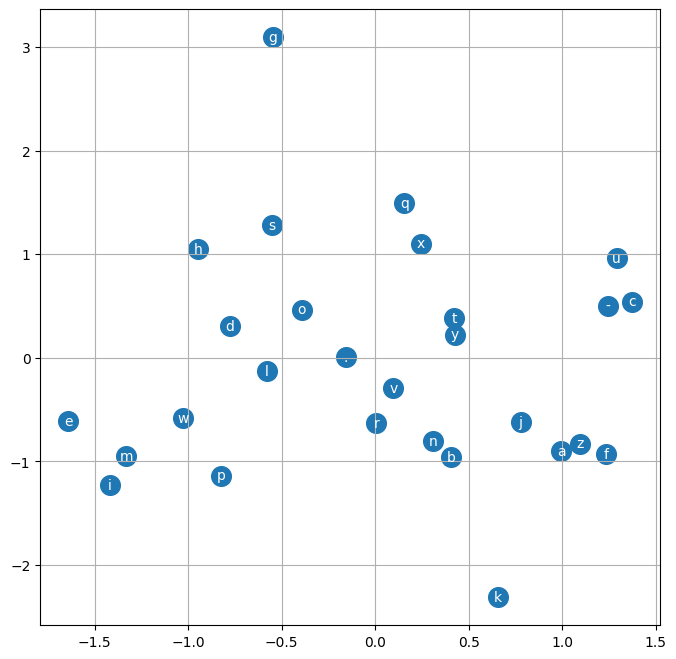

In [452]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i],
             ha="center", va="center", color="white")
    plt.grid('minor')

Another way to embed characters is the [**one-hot encoding**](https://pytorch.org/docs/stable/generated/torch.nn.functional.one_hot.html) discussed last lecture.
We can see this embedding as the first layer of our network, even if there's no linearity in it.
In fact, they're completely equivalent.
One can also see all the embeddings.

In [453]:
print(F.one_hot(torch.tensor(5), num_classes=28))
print(F.one_hot(torch.tensor(5), num_classes=28).float()@C)
print(C[5])
print(C[Y])

tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0])
tensor([-0.7776,  0.3077])
tensor([-0.7776,  0.3077])
tensor([[ 0.9940, -0.8991],
        [ 0.0061, -0.6300],
        [-0.5460,  3.0955],
        [-1.6397, -0.6131],
        [ 0.3087, -0.8025],
        [ 0.4220,  0.3822],
        [-0.3936,  0.4641],
        [-0.1584,  0.0036],
        [-0.5460,  3.0955],
        [-1.4187, -1.2333],
        [-0.3936,  0.4641],
        [ 0.0970, -0.2923],
        [ 0.9940, -0.8991],
        [ 0.3087, -0.8025],
        [ 0.3087, -0.8025],
        [-1.4187, -1.2333],
        [ 0.3087, -0.8025],
        [-0.3936,  0.4641],
        [-0.1584,  0.0036],
        [-0.5780, -0.1284],
        [-1.4187, -1.2333],
        [ 1.3726,  0.5412],
        [ 1.2897,  0.9605],
        [ 0.0061, -0.6300],
        [-0.5460,  3.0955],
        [ 0.9940, -0.8991],
        [-0.1584,  0.0036],
        [-1.6397, -0.6131],
        [-0.5780, -0.1284],
        [ 0.0970, -0.2923],
     

How to embed the 41 trigrams we have?

In [454]:
emb = C[X]
print(emb.shape)

torch.Size([41, 3, 2])


Moreover, we can *differentiate* C!
Input has dimension 6 = 3 * 2

In [455]:
# construct the Layer.... x.W+ b ... so the input has dimension 6=3*2 for (say) 100 neurons...
W1 = torch.randn(6, 100)
b1 = torch.randn(100)

We want to concatenate tensors.
And maybe unbind them.

In [456]:
# https://pytorch.org/docs/stable/torch.html search for concatenate...

print(torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1)[1])
print(emb[1])

tensor([-0.1584,  0.0036, -0.1584,  0.0036,  0.9940, -0.8991])
tensor([[-0.1584,  0.0036],
        [-0.1584,  0.0036],
        [ 0.9940, -0.8991]])


In [457]:
# we want a code for general n-grams.....
# use 'unbind' https://pytorch.org/docs/stable/generated/torch.unbind.html#torch.unbind
len(torch.unbind(emb, 1))

3

In [458]:
# and this work fore any context length.......

torch.cat(torch.unbind(emb, 1), 1)

tensor([[-0.1584,  0.0036, -0.1584,  0.0036, -0.1584,  0.0036],
        [-0.1584,  0.0036, -0.1584,  0.0036,  0.9940, -0.8991],
        [-0.1584,  0.0036,  0.9940, -0.8991,  0.0061, -0.6300],
        [ 0.9940, -0.8991,  0.0061, -0.6300, -0.5460,  3.0955],
        [ 0.0061, -0.6300, -0.5460,  3.0955, -1.6397, -0.6131],
        [-0.5460,  3.0955, -1.6397, -0.6131,  0.3087, -0.8025],
        [-1.6397, -0.6131,  0.3087, -0.8025,  0.4220,  0.3822],
        [ 0.3087, -0.8025,  0.4220,  0.3822, -0.3936,  0.4641],
        [-0.1584,  0.0036, -0.1584,  0.0036, -0.1584,  0.0036],
        [-0.1584,  0.0036, -0.1584,  0.0036, -0.5460,  3.0955],
        [-0.1584,  0.0036, -0.5460,  3.0955, -1.4187, -1.2333],
        [-0.5460,  3.0955, -1.4187, -1.2333, -0.3936,  0.4641],
        [-1.4187, -1.2333, -0.3936,  0.4641,  0.0970, -0.2923],
        [-0.3936,  0.4641,  0.0970, -0.2923,  0.9940, -0.8991],
        [ 0.0970, -0.2923,  0.9940, -0.8991,  0.3087, -0.8025],
        [ 0.9940, -0.8991,  0.3087, -0.8

Let's see a better way.

In [459]:
# https://pytorch.org/docs/stable/generated/torch.Tensor.view.html

# https://pytorch.org/docs/stable/generated/torch.Tensor.stride.html

a = torch.arange(18)
print(a)
print(a.shape)
print(a.view(9, 2))
print(a.view(2, 9))
print(a.untyped_storage())  # very efficient in torch

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])
torch.Size([18])
tensor([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11],
        [12, 13],
        [14, 15],
        [16, 17]])
tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17]])
 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]


/tmp/ipykernel_494/1622729900.py:12: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  print(a.storage()) # very efficient in torch


In [460]:
print(emb.view(41, 6) == torch.cat(torch.unbind(emb, 1), 1))

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

So we can use

In [461]:
h = emb.view(41, 6) @ W1 + b1

In [462]:
print(h)
print(h.shape)
# -1 means 'infer' the dimension from the other dimensions (sort-of auto)
print(emb.view(-1, 6) @ W1 + b1)

tensor([[-0.0127, -1.5797,  0.3777,  ...,  0.8798,  0.8424,  0.3150],
        [ 0.4762, -1.6867,  2.4601,  ..., -1.1835,  1.1385,  1.0527],
        [-2.4161, -1.6783,  2.7843,  ..., -1.8970, -1.9951,  0.8419],
        ...,
        [ 0.0383, -0.0525,  3.2570,  ...,  2.5062, -3.9853, -0.9087],
        [ 1.8422, -0.6354,  2.8349,  ...,  1.2162, -0.9053, -1.1034],
        [-0.7111, -4.3180,  3.8939,  ..., -3.6111,  0.0440,  2.0282]])
torch.Size([41, 100])
tensor([[-0.0127, -1.5797,  0.3777,  ...,  0.8798,  0.8424,  0.3150],
        [ 0.4762, -1.6867,  2.4601,  ..., -1.1835,  1.1385,  1.0527],
        [-2.4161, -1.6783,  2.7843,  ..., -1.8970, -1.9951,  0.8419],
        ...,
        [ 0.0383, -0.0525,  3.2570,  ...,  2.5062, -3.9853, -0.9087],
        [ 1.8422, -0.6354,  2.8349,  ...,  1.2162, -0.9053, -1.1034],
        [-0.7111, -4.3180,  3.8939,  ..., -3.6111,  0.0440,  2.0282]])


Embed (glue) + apply matrix + add b1.
Now apply a non-linear transformation like hyperbolic tangent.

In [463]:
# first layer

# https://pytorch.org/docs/stable/generated/torch.tanh.html

h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [464]:
print(h)

tensor([[-0.0127, -0.9185,  0.3607,  ...,  0.7063,  0.6871,  0.3050],
        [ 0.4432, -0.9337,  0.9855,  ..., -0.8285,  0.8139,  0.7829],
        [-0.9842, -0.9326,  0.9924,  ..., -0.9560, -0.9637,  0.6868],
        ...,
        [ 0.0383, -0.0525,  0.9970,  ...,  0.9868, -0.9993, -0.7205],
        [ 0.9510, -0.5618,  0.9931,  ...,  0.8385, -0.7189, -0.8017],
        [-0.6113, -0.9996,  0.9992,  ..., -0.9985,  0.0440,  0.9660]])


Second layer must take in 100D vector and give out a 28D vector.

In [465]:
# second layer

W2 = torch.randn((100, 28))
b2 = torch.randn(28)

h is coming out from the first layer, then we feed with h the layer here.

In [466]:
logits = h @ W2 + b2
print(logits.shape)

torch.Size([41, 28])


Logits means log of the counting...

In [467]:
counts = logits.exp()

Normalize to interpret this as a measure, i.e. a probability distribution coming out from the network when fed with three chars.

In [468]:
prob = counts / counts.sum(1, keepdims=True)

In [469]:
print(prob[0])
print(prob[0].sum())
print(prob[0, 1])
print(prob[[0, 1], [2, 5]])

tensor([9.7717e-07, 1.1903e-09, 1.1622e-03, 1.3884e-04, 1.2119e-07, 1.4373e-08,
        3.7337e-08, 5.9759e-07, 4.1920e-10, 1.5534e-08, 9.1641e-01, 4.8512e-11,
        6.0606e-07, 1.0638e-03, 9.7434e-06, 3.2012e-06, 3.8229e-08, 1.5657e-07,
        3.3748e-03, 1.0385e-06, 2.4357e-05, 6.0491e-09, 2.8107e-14, 7.6021e-12,
        7.7808e-02, 1.6660e-08, 2.7311e-11, 9.1822e-10])
tensor(1.0000)
tensor(1.1903e-09)
tensor([1.1622e-03, 1.7094e-10])


Model is initialized with random weights, so it's making mistakes.

In [470]:
print(Y)
print(torch.arange(41))
print(prob[torch.arange(41), Y])

tensor([ 2, 19,  8,  6, 15, 21, 16,  0,  8, 10, 16, 23,  2, 15, 15, 10, 15, 16,
         0, 13, 10,  4, 22, 19,  8,  2,  0,  6, 13, 23, 10, 19,  2,  0, 14,  2,
        19,  6, 15,  2,  0])
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40])
tensor([1.1622e-03, 1.3647e-10, 1.2721e-10, 7.4825e-06, 4.3084e-15, 2.0606e-09,
        4.9061e-08, 5.3828e-07, 4.1920e-10, 7.6886e-08, 4.0766e-01, 1.1818e-09,
        2.8867e-08, 3.2134e-04, 5.7727e-05, 3.4768e-12, 1.0444e-11, 7.0611e-15,
        1.1958e-08, 1.0638e-03, 9.8603e-01, 5.7557e-09, 1.4726e-06, 7.5069e-07,
        5.9529e-17, 3.8195e-05, 4.3590e-09, 3.7337e-08, 1.0221e-06, 1.0162e-11,
        3.0114e-01, 4.2972e-04, 5.7576e-08, 1.1595e-06, 9.7434e-06, 1.8131e-09,
        6.9818e-13, 2.9324e-11, 1.8745e-15, 9.2900e-11, 6.4576e-09])


We, of course, want the model to predict the right answer.
Probability going to one implies loss going to zero.

In [471]:
loss = - prob[torch.arange(41), Y].log().mean()
print(loss)  # very bad of course.....

tensor(17.5833)


Let's put things together.
Parameters will contain all the objects we're going to change.
Why is the embedding dimension 2? We'll try with 10...
$\tanh 0 = 0$ and that will be important.

In [472]:
g = torch.Generator().manual_seed(123456780)  # for reproducibility
C = torch.randn((28, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 28), generator=g)
b2 = torch.randn(28, generator=g)
parameters = [C, W1, b1, W2, b2]

How many parameters are fixable?

In [473]:
print(sum(p.nelement() for p in parameters))  # number of parameter in total...

3584


For each sample I compute the log → high loss.

In [474]:
emb = C[X]  # torch.Size([41, 3, 2])
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (41,100)
logits = h @ W2 + b2  # (41,27)
counts = logits.exp()
prob = counts/counts.sum(1, keepdims=True)
loss = -prob[torch.arange(41), Y].log().mean()
print(loss)

tensor(17.2342)


Very efficient and can compute the exponential of big terms

In [475]:
print(F.cross_entropy(logits, Y))

tensor(17.2342)


Now the loss has to be minimized.

In [476]:
# so..... https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html
emb = C[X]  # torch.Size([41, 3, 2])
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (41,100)
logits = h @ W2 + b2  # (41,27)
loss = F.cross_entropy(logits, Y)
print(loss)

tensor(17.2342)


We'll use the cross_entropy function because the exponentiation of just -500 will result in 0

In [477]:
# two very good reasons to use 'cross_entropy': more efficient (no tensor) and substract the maximum to avoid nan....discuss....

logits = torch.tensor([-5, -3, 0, 10])  # -100
counts = logits.exp()
prob = counts/counts.sum()
print(counts)
print(prob)

tensor([6.7379e-03, 4.9787e-02, 1.0000e+00, 2.2026e+04])
tensor([3.0589e-07, 2.2602e-06, 4.5398e-05, 9.9995e-01])


Put the gradient to zero, then compute the backward derivative and update all parameters in order to decrease the loss.
41 trigrams are going in layers, then calculate the loss.

Backward pass means compute the derivative of the loss for each parameter.
It's a very complex stuff.
We're not happy with back propagation but, by now, it's the only thing which works.

Learning rate -0.1 (negative direction).
This is a magic number.

In [478]:
for p in parameters:
    p.requires_grad = True

for _ in range(1000):
    # now we learn...forward bass
    emb = C[X]  # torch.Size([41, 3, 2])
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (41,100)
    logits = h @ W2 + b2  # (41,27)
    loss = F.cross_entropy(logits, Y)
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -0.1*p.grad

Low loss means overfitting, then the model is going to give me one of the sample I provided.
This is not useful at all.

In [479]:
# sampling from the model.....

g = torch.Generator().manual_seed(12345678+10)

for _ in range(20):
    out = []
    context = [0]*block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:]+[ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

elvira.
marena.
giovannino.
giovannino.
giovannino.
giovannino.
elvira.
marena.
argento.
argento.
argento.
elvira.
argento.
licurga.
licurga.
marena.
giovannino.
marena.
giovannino.
licurga.


What is happening? Our model has gone in **overfitting**: it is spitting out the same names we put in, since we trained it only on those small samples (we've given it only 5 samples out of 7000+...)!
So the loss is low enough now to sample, but of course our model is still useless.
How can we fix this?

If we try to train the system with the whole data set (so that all the $41$'s are changed to the dimension of the dataset, that's the only change in the code) we fix the overfitting problem, but the algorithm will of course slow down in order to make the same calculations for such high dimensionality. 

To fix this problem, we need to use **minibatches**.

In [480]:
for p in parameters:
    p.requires_grad = True

for _ in range(1000):
    # now we learn...forward bass
    emb = C[X]  # torch.Size([41, 3, 2])
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (41,100)
    logits = h @ W2 + b2  # (41,27)
    loss = F.cross_entropy(logits, Y)
    # print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -0.1*p.grad
print(loss.item())

0.19916315376758575


Logits are the neurons coming out from the last layer.
They'll be transformed into probability.

In [481]:
print(logits.max(1))
print(Y)

torch.return_types.max(
values=tensor([12.1724, 14.1847, 15.8096, 16.5460, 12.5090, 14.7062, 15.2590, 15.4024,
        12.1724, 19.3660, 15.9273, 12.4720, 13.9841, 17.1356, 14.9285, 13.9812,
        13.8305, 15.1462, 14.5532, 12.1724, 15.2042, 17.6397, 14.6976, 14.7785,
        22.7934, 18.4190, 15.3254, 12.1724, 18.8153, 16.9008, 17.9443, 18.5473,
        15.9427, 15.7163, 12.1724, 19.9722, 15.4614, 16.7053, 16.1372, 18.4218,
        15.9050], grad_fn=<MaxBackward0>),
indices=tensor([13, 19,  8,  6, 15, 21, 16,  0, 13, 10, 16, 23,  2, 15, 15, 10, 15, 16,
         0, 13, 10,  4, 22, 19,  8,  2,  0, 13, 13, 23, 10, 19,  2,  0, 13,  2,
        19,  6, 15,  2,  0]))
tensor([ 2, 19,  8,  6, 15, 21, 16,  0,  8, 10, 16, 23,  2, 15, 15, 10, 15, 16,
         0, 13, 10,  4, 22, 19,  8,  2,  0,  6, 13, 23, 10, 19,  2,  0, 14,  2,
        19,  6, 15,  2,  0])


Taking all words we get a very big example dataset.

In [482]:
block_size = 3  # context length: how many characters do we take to predict the next one ... change it !!
X, Y = [], []  # input & label

for w in words:
  #  print(w)
    context = [0]*block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
      #  print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:]+[ix]  # shift: crop and append
X = torch.tensor(X)
Y = torch.tensor(Y)

In [483]:
print(X.shape, Y.shape)

torch.Size([73643, 3]) torch.Size([73643])


Again, a hidden layer of 100 neurons.

In [484]:
# exactly as before....
g = torch.Generator().manual_seed(123456780)  # for reproducibility
C = torch.randn((28, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 28), generator=g)
b2 = torch.randn(28, generator=g)
parameters = [C, W1, b1, W2, b2]

In [485]:
for p in parameters:
    p.requires_grad = True

for _ in range(10):
    # now we learn...forward bass -- = 73643
    emb = C[X]  # torch.Size([--, 3, 2])
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (--,100)
    logits = h @ W2 + b2  # (--,27)
    loss = F.cross_entropy(logits, Y)
    print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -0.1*p.grad

17.754497528076172
15.824398040771484
14.187443733215332
13.052313804626465
12.071905136108398
11.263842582702637
10.603142738342285
10.075033187866211
9.627379417419434
9.222493171691895


See how it's slowing down...
Every time we give all samples to it.
Let's subdivide the dataset in minibatches.

In [486]:
# try ix=torch.randint(0,X.shape[0],(10,2)) and explain
ix = torch.randint(0, X.shape[0], (10,))
# https://pytorch.org/docs/stable/generated/torch.randint.html
print(ix)

tensor([65739, 57246, 73039, 50426, 60229,  1076, 10994, 71617, 42058, 29497])


Weird things happen with PyTorch...

In [487]:
ix = torch.randint(0, X.shape[0], (10, 1))
print(ix)

tensor([[57686],
        [ 8590],
        [18991],
        [31694],
        [56747],
        [36820],
        [19621],
        [15325],
        [65718],
        [48395]])


In [488]:
for _ in range(10):
    # mini batch construct of size ...
    ix = torch.randint(0, X.shape[0], (32,))
    # now we learn...forward bass -- = 73643
    emb = C[X[ix]]  # torch.Size([--, 3, 2])
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (--,100)
    logits = h @ W2 + b2  # (--,27)
    loss = F.cross_entropy(logits, Y[ix])
    print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -0.1*p.grad
print(loss.item())

9.076169967651367
8.107839584350586
7.53472900390625
8.057098388671875
9.006769180297852
6.839514255523682
6.016563415527344
7.071707725524902
6.523996353149414
6.122567653656006
6.122567653656006


Learning rate specifies how I move through gradient.
Using 10, the system got completely lost (too big jumps).

In [489]:
# how we define the 'learning rate' ? p.data += -0.1*p.grad
# play with learning rate from .01 to 100.... and discuss

In [490]:
for _ in range(1000):
    # mini batch construct
    ix = torch.randint(0, X.shape[0], (100,))
    # now we learn...forward bass -- = 73643
    emb = C[X[ix]]  # torch.Size([--, 3, 2])
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (--,100)
    logits = h @ W2 + b2  # (--,27)
    loss = F.cross_entropy(logits, Y[ix])
    # print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -.1*p.grad
print(loss.item())

2.3013787269592285


In [491]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre  # from 10**-3 to 10**0 = 1. The exponents are linearly distributed, not the values
print(lrs.shape)

torch.Size([1000])


In [492]:
for p in parameters:
    p.requires_grad = True

lri = []
lriex = []
lossi = []


for i in range(1000):
    # mini batch construct
    ix = torch.randint(0, X.shape[0], (100,))
    # now we learn...forward bass -- = 73643
    emb = C[X[ix]]  # torch.Size([--, 3, 2])
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (--,100)
    logits = h @ W2 + b2  # (--,27)
    loss = F.cross_entropy(logits, Y[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = lrs[i]
    # lr= .01
    for p in parameters:
        p.data += -lr*p.grad

# track stats
    lri.append(lr)  # learning rate
    lriex.append(lre[i])  # exponent
    lossi.append(loss.item())  # loss function
print(loss.item())

5.072561264038086


Plotting the loss function we notice that it's growing... not good.

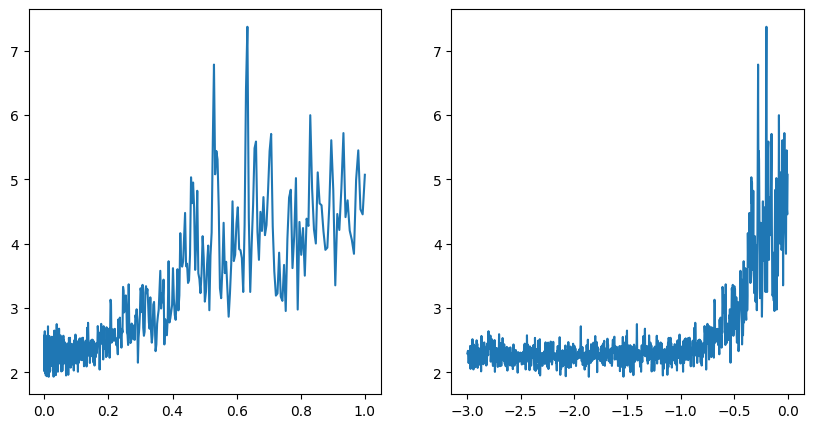

In [493]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(lri, lossi)
ax[1].plot(lriex, lossi)

What is happening to the loss? 
There are some values of the learning rate which do better for our loss function than others.
Also, it's very much fluctuating: there is a brilliant solution for this problem which we will see later on.

Usually, the convention with the training data is to have it split into $80 \%$ to train, a $10 \%$ to validate the hyperparameters and then a final $10 \%$ to keep there and use only once to see if the Neural Network is actually doing good.

How to validate that the network is doing something good?
It may seem good while being completely wrong.
We should have a test set of data to use when the hyperparameters are fixed.

In [494]:
emb = C[X]  # torch.Size([41, 3, 2])
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (41,100)
logits = h @ W2 + b2  # (41,27)
loss = F.cross_entropy(logits, Y)
print(loss)

tensor(4.5317, grad_fn=<NllLossBackward0>)


Typically, data are divided into 80-10-10 part (test/tune/validation)
This function shuffles the words and builds the three wanted datasets.

First let's define the function *build dataset*.

In [495]:
# be careful with the test eugene.....

def build_dataset(words):
    block_size = 3  # context length: how many characters do we take to predict the next one ... change it !!
    X, Y = [], []  # input & label

    for w in words:
        context = [0]*block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
      #  print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:]+[ix]  # shift: crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [496]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])  # train
Xdev, Ydev = build_dataset(words[n1:n2])  # tune hyperparameters
Xte, Yte = build_dataset(words[n2:])  # validate

torch.Size([58867, 3]) torch.Size([58867])
torch.Size([7404, 3]) torch.Size([7404])
torch.Size([7372, 3]) torch.Size([7372])


In [497]:
# and we do it again with the new datasets.......
print(Xtr.shape, Ytr.shape)

# exactly as before....
g = torch.Generator().manual_seed(123456780)  # for reproducibility
C = torch.randn((28, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 28), generator=g)
b2 = torch.randn(28, generator=g)
parameters = [C, W1, b1, W2, b2]

torch.Size([58867, 3]) torch.Size([58867])


In [498]:
for p in parameters:
    p.requires_grad = True


lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [499]:
# now we train only on Xtr

lri = []
lriex = []
lossi = []


for i in range(10000):
    # mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (40,))
    # now we learn...forward bass -- = 73643
    emb = C[Xtr[ix]]  # torch.Size([--, 3, 2])
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (--,100)
    logits = h @ W2 + b2  # (--,27)
    loss = F.cross_entropy(logits, Ytr[ix])
   # print(i,loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    # lr=lrs[i]
    lr = .1
    for p in parameters:
        p.data += -lr*p.grad
print(loss.item())

# track stats
#    lri.append(lr)
#    lriex.append(lre[i])
#    lossi.append(loss.item())

2.018704652786255


Now evaluate on the validation test (and also on the test).

In [500]:
# now we evaluate on Xdev
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (--,100)
logits = h @ W2 + b2  # (--,27)
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.1819050312042236


In [501]:
# now we evaluate on Xtr..... we are NOT overfitting
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (--,100)
logits = h @ W2 + b2  # (--,27)
loss = F.cross_entropy(logits, Ytr)
print(loss.item())

2.172853708267212


So now we know that our model has a low loss **and** we are not overfitting, my system is able to reproduce not only the data I show it in the training but also other data it has never seen before.
Nice...

Now we can change the hyperparameters: this is a very simple case, so it's not going to change much, but still we do it for pedagogical reasons.
Even in such a simple model, changing the hyperparameters makes our parameters go from $\sim 3000$ to $\sim 10000$. 
Let's take a look at what happens now to the loss...

In [502]:
g = torch.Generator().manual_seed(123456780)  # for reproducibility
C = torch.randn((28, 2), generator=g)
W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 28), generator=g)
b2 = torch.randn(28, generator=g)
parameters = [C, W1, b1, W2, b2]

In [503]:
# number of parameter in total... before 3584
print(sum(p.nelement() for p in parameters))

10584


In [504]:
lri = []
lriex = []
lossi = []
stepi = []
for p in parameters:
    p.requires_grad = True

for i in range(10000):
    # mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (40,))
    # now we learn...forward bass -- = 73643
    emb = C[Xtr[ix]]  # torch.Size([--, 3, 2])
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # (--,100)
    logits = h @ W2 + b2  # (--,27)
    loss = F.cross_entropy(logits, Ytr[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    # lr=lrs[i]
    lr = .1
    for p in parameters:
        p.data += -lr*p.grad
    stepi.append(i)
    lossi.append(loss.item())

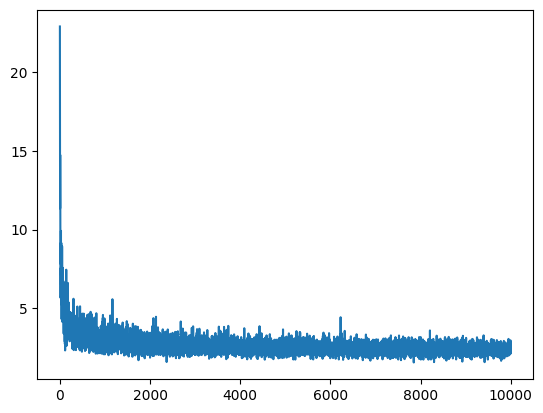

In [505]:
plt.plot(stepi, lossi)

We can see how the loss starts very high and then decreases very much with training, but still it is fluctuating: this shouldn't be very surprising, since even with training our model is based on random number and processes, so fluctuations are guaranteed.
But as we said before, there is a nice way to reduce these fluctuations, which is called **batch normalization**.

This is a transformation we make our data undergo in order to have a "gaussian" activity of our neurons.
In this way we avoid $2$ things:
1. we avoid our neurons' activity being too high, i.e. we do not want values which would mostly fall into the plateaus of our hyperbolic tangent and thus cause the "freezing" of our neurons, i.e. their inability to learn, since their output would always be $+1$ or $-1$ and no in between;
2. we avoid large fluctuations in our data, since gaussian data fluctuations scale as we know with $\frac{1}{\sqrt{N}}$ where $N$ is the number of samples. Such transformation is (roughly speaking) just gaussian normalization of data (actually there are more complex operations going on in the *batch-normalization* functions of libraries like PyTorch, and we actually do not know much about the precise statistical effectiveness of such processes, we use them as kind of "black box"), before feeding them to the linear layer, i.e. data are normalized before the hyperbolic tangent application. This means that we take the sample mean of our data $\bar{x} = \sum_i^N \frac{x_i}{N}$, compute the sample standard deviation $\sigma_s$ and then transform each point $x$ of our set by
$$
    x \longrightarrow \frac{x - \bar{x}}{\sigma_s} 
$$
We will use batch normalization later on.

Now we can visualize the result of the embedding.
The letters are clustered, e.g. vowels are clustered.

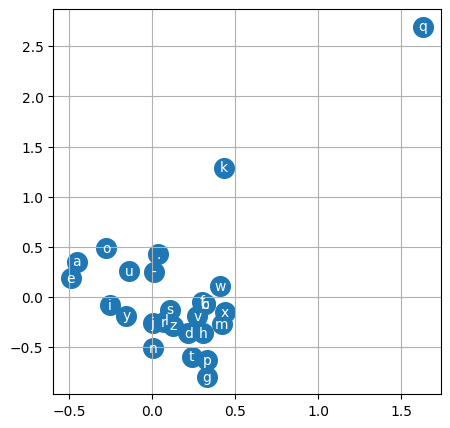

In [506]:
plt.figure(figsize=(5, 5))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i],
             ha="center", va="center", color="white")
    plt.grid('minor')

Now increase to 10 the embedding dimension...

In [507]:
g = torch.Generator().manual_seed(123456780)  # for reproducibility
C = torch.randn((28, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 28), generator=g)
b2 = torch.randn(28, generator=g)
parameters = [C, W1, b1, W2, b2]

In [508]:
print(sum(p.nelement() for p in parameters))  # number of parameter in total

12108


In [509]:
lri = []
lriex = []
lossi = []
stepi = []

for p in parameters:
    p.requires_grad = True

Now change the learning rate...

In [510]:
for i in range(200000):

    # mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (40,))
    # now we learn...forward bass -- = 73643
    emb = C[Xtr[ix]]  # torch.Size([--, 3, 2])
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # (--,100)
    logits = h @ W2 + b2  # (--,27)
    loss = F.cross_entropy(logits, Ytr[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = .1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr*p.grad
    stepi.append(i)
    lossi.append(loss.log10().item())  # note the log10 !!

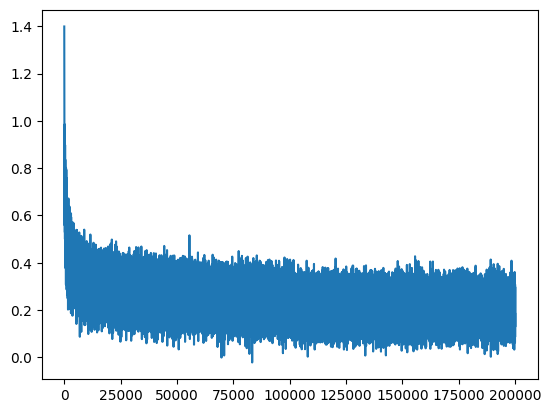

In [511]:
plt.plot(stepi, lossi)

We're doing well and not overfitting.

In [512]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # (--,100)   30 not 6 !
logits = h @ W2 + b2  # (--,27)
loss = F.cross_entropy(logits, Ytr)
print(loss.item())

1.6529531478881836


In [513]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # (--,100)
logits = h @ W2 + b2  # (--,27)
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

1.8500275611877441


Once trained the model we can sample from it.
**NOTE**: there are many (many many) hyperparameters to play with, like the number of layer, numbers of neurons from layers, embedding dimensions, dimension of the batches, learning rate....

We can now see words that are not in the dataset.

In [514]:
# g = torch.Generator().manual_seed(12345678+10)

for _ in range(30):
    out = []
    context = [0]*block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:]+[ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

ade.
galdina.
crescenzu.
erto.
marinanto.
divia.
deciano.
ermiro.
dircolo.
arleolomurita.
gusina.
ristofelastrrino.
chrica.
mea.
pina.
pedermen.
ave.
alimolando.
gertaudino.
speramina.
orlino.
orlide.
venzion-idalma.
is.
asdina.
clemiglia.
zelminio.
brunino.
esio.
doluttunaa.


Not bad!
We see names that were not in the original dataset, and much more "name-like" than the previous examples.